In [1]:
import torch as th
import numpy as np
import pickle
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from pytorch_lightning import seed_everything
import torch as th
import tqdm
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import sys
sys.path.insert(0, '../../sample_scripts/')
import glob
import warnings
warnings.filterwarnings("ignore")

from sample_scripts.sample_utils.inference_utils import to_tensor
from sample_scripts.sample_utils.vis_utils import plot_image
from sample_scripts.sample_utils import (
    ckpt_utils, 
    file_utils,
    params_utils,
)
from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

device = 'cuda:1'

plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs, size=17):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(size, size))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def get_cfg(self):
    from config.base_config import parse_args
    cfg_file_path = glob.glob("/home/mint/guided-diffusion/config/*/*", recursive=True)
    cfg_file_path = [cfg_path for cfg_path in cfg_file_path if f"/{self.cfg_name}" in cfg_path]    # Add /{}/ to achieve a case-sensitive of folder
    print("[#] Config Path : ", cfg_file_path)
    assert len(cfg_file_path) <= 1
    assert len(cfg_file_path) > 0
    cfg_file = cfg_file_path[0]
    cfg = parse_args(ipynb={'mode':True, 'cfg':cfg_file})
    return cfg

In [2]:
ckpt_loader = ckpt_utils.CkptLoader(log_dir="UNetCond_Spatial_Concat_Shape", cfg_name="UNetCond_Spatial_Concat_Shape.yaml")
cfg = ckpt_loader.cfg
cfg.img_cond_model.in_image = cfg.img_cond_model.in_image + ['faceseg_bg_noface&nohair'] + ['faceseg_eyes']
cfg.img_cond_model.prep_image = [None, None, None]
cfg.img_model.image_size = 256
# Load dataset
img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"

loader, dataset, _ = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector + ['albedo'],
    rmv_params=cfg.param_model.rmv_params,
    set_='valid',
    cfg=cfg,
)

# _, _, avg_dict = load_data_img_deca(
#     data_dir=img_dataset_path,
#     deca_dir=deca_dataset_path,
#     batch_size=int(1e7),
#     image_size=cfg.img_model.image_size,
#     deterministic=cfg.train.deterministic,
#     augment_mode=cfg.img_model.augment_mode,
#     resize_mode=cfg.img_model.resize_mode,
#     in_image_UNet=cfg.img_model.in_image,
#     params_selector=cfg.param_model.params_selector + ['albedo'],
#     rmv_params=cfg.param_model.rmv_params,
#     set_='train',
#     cfg=cfg,
# )

[#] Model Path :  ['/data/mint/model_logs_mount/v12/UNetCond_Spatial_Concat_Shape/']
[#] Config Path :  ['/home/mint/guided-diffusion/config/EncLight_Spatial_Rendered_Face/UNetCond_Spatial_Concat_Shape.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/EncLight_Spatial_Rendered_Face/UNetCond_Spatial_Concat_Shape.yaml')



Loading deca params...: 100%|██████████| 9/9 [00:07<00:00,  1.16it/s]


[#] Parameters Conditioning
Params keys order :  ['shape', 'pose', 'exp', 'cam', 'faceemb']
Remove keys :  []


# Generate Masks from keypoints

In [27]:
set_ = 'train'
kpts_2d = file_utils._list_npy_files_recursively(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/keypoints/keypoints_2d/{set_}/")
img_file = file_utils._list_image_files_recursively(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/")
img_size = 256
import cv2
from PIL import Image
mask_out = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/eyes_segment/{set_}/"
os.makedirs(mask_out, exist_ok=True)

drawing_set = [[36, 37, 38, 39], [36, 39, 40, 41], [42, 43, 44, 45], [42, 45, 46, 47]]
for i, kpt_file in enumerate(tqdm.tqdm(kpts_2d)):
    name = kpt_file.split('/')[-1].split('.')[0]
    lm = np.load(kpt_file, allow_pickle=True) * img_size/2 + img_size/2
    img_mask = np.array(Image.open(img_file[i]))
    mask = np.zeros_like(img_mask)
    assert (name in kpt_file) and (name in img_file[i])
    for d in drawing_set:
        lm_tmp = lm[d, :].astype(np.int32)
        cv2.fillPoly(img_mask, pts = [lm_tmp], color =(255,255,255))
        cv2.fillPoly(mask, pts = [lm_tmp], color =(255,255,255))
    # plt.imshow(np.concatenate((img_mask, mask), 1))
    # plt.show()
    assert np.all(np.abs(mask[..., 0] - mask[..., 1]) < 1e-6)
    assert np.all(np.abs(mask[..., 0] - mask[..., 2]) < 1e-6)
    assert np.all(np.abs(mask[..., 1] - mask[..., 2]) < 1e-6)
    mask_img = Image.fromarray(mask)
    mask_img.save(fp=f"{mask_out}/{name}.png")

100%|██████████| 60000/60000 [03:02<00:00, 327.93it/s]


# Generate Laplacian features

  0%|          | 0/60000 [00:00<?, ?it/s]

0.24455398858762245 -0.3274224973192402
189.86126708984372 44.00726318359374


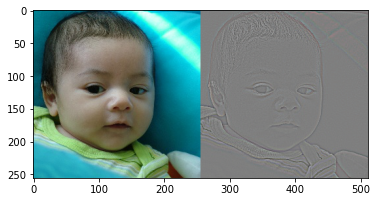

  0%|          | 1/60000 [00:00<1:57:29,  8.51it/s]

189
44
0.5793337354473039 -0.2949283375459559
275.23010253906256 52.29327392578125


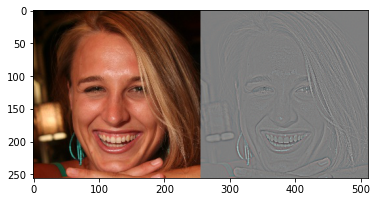

  0%|          | 2/60000 [00:00<1:50:16,  9.07it/s]

253
10
0.6552772671568627 -0.3640064912683824
294.595703125 34.678344726562486


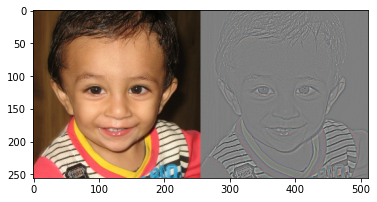

  0%|          | 3/60000 [00:00<1:52:25,  8.89it/s]

247
34
0.44811030369178917 -0.3312157724417893
241.76812744140625 43.03997802734373


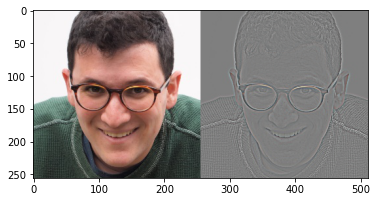

241
43
0.561523916207108 -0.5165699678308824
270.6885986328125 -4.225341796875007


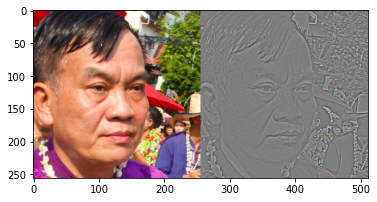

  0%|          | 5/60000 [00:00<1:45:29,  9.48it/s]

252
0
0.46046190448835783 -0.3408844592524509
244.91778564453122 40.574462890625014


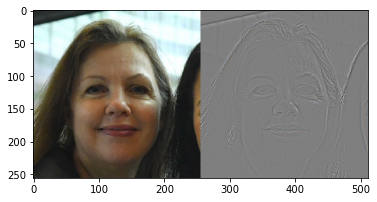

  0%|          | 6/60000 [00:00<1:46:12,  9.41it/s]

244
40
0.7042150160845587 -0.6300589767156863
307.07482910156244 -33.165039062500014


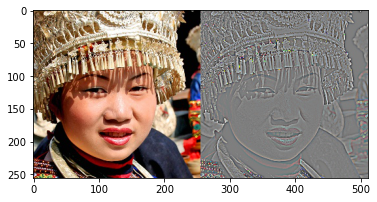

  0%|          | 7/60000 [00:00<1:48:21,  9.23it/s]

255
0
0.5578957950367647 -0.31519272748161764
269.763427734375 47.1258544921875


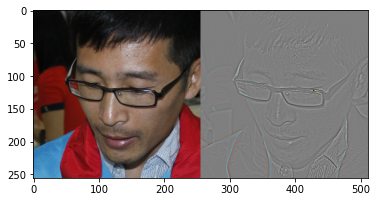

  0%|          | 8/60000 [00:00<1:46:27,  9.39it/s]

255
1
0.5287267348345588 -0.3027535232843137
262.3253173828125 50.29785156250001


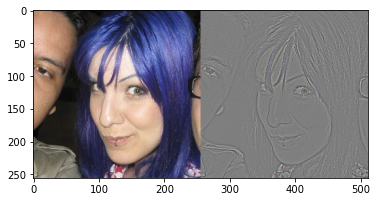

  0%|          | 9/60000 [00:00<1:44:52,  9.53it/s]

251
0
0.43384674670649503 -0.5190803079044117
238.13092041015622 -4.865478515624991


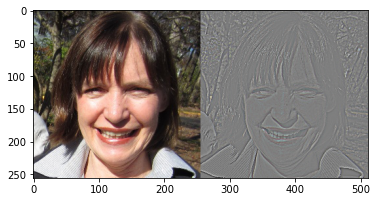

  0%|          | 10/60000 [00:01<1:44:00,  9.61it/s]

252
9
0.5100291532628677 -0.3370337392769607
257.55743408203125 41.55639648437503


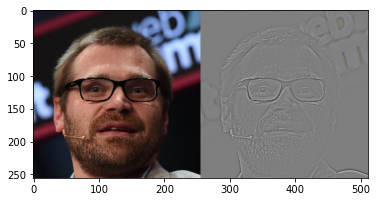

  0%|          | 11/60000 [00:01<1:43:52,  9.62it/s]

252
0
0.4780199237898284 -0.3300005744485294
249.39508056640625 43.34985351562499


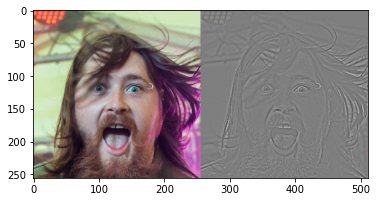

  0%|          | 12/60000 [00:01<1:42:52,  9.72it/s]

249
43
0.8062555051317402 -0.46668677236519607
333.09515380859375 8.494873046875004


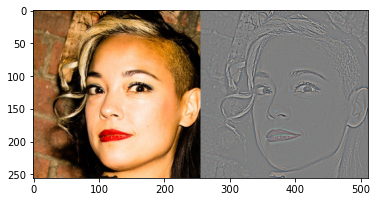

  0%|          | 13/60000 [00:01<1:42:24,  9.76it/s]

254
1
0.3867115693933823 -0.3214884440104166
226.11145019531247 45.52044677734377


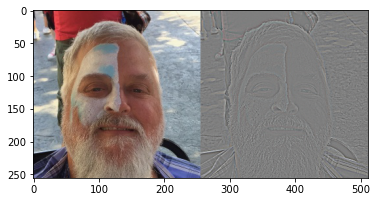

  0%|          | 14/60000 [00:01<1:43:54,  9.62it/s]

226
45
0.4380055147058823 -0.449758731617647
239.19140625 12.811523437500012


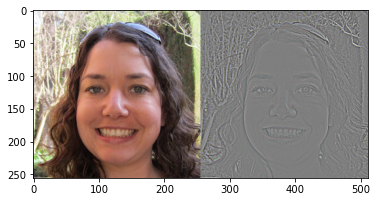

239
12
0.5744710286458333 -0.546279488357843
273.99011230468744 -11.801269531249968


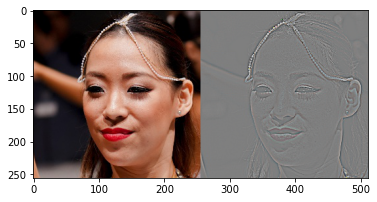

  0%|          | 16/60000 [00:01<1:41:44,  9.83it/s]

255
0
0.6708756989123774 -0.6326042624080882
298.57330322265625 -33.81408691406249


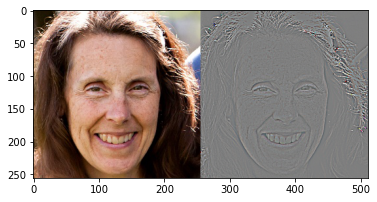

255
0
0.7663203220741421 -0.28857421874999994
322.91168212890625 53.913574218750014


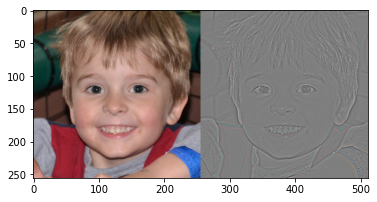

  0%|          | 18/60000 [00:01<1:40:57,  9.90it/s]

225
53
0.3217766256893382 -0.4283083448223039
209.55303955078125 18.281372070312507


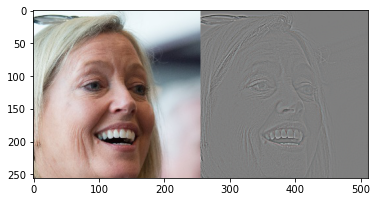

  0%|          | 19/60000 [00:02<2:09:49,  7.70it/s]

209
18
0.4785802504595588 -0.4226282456341912
249.5379638671875 19.72979736328124


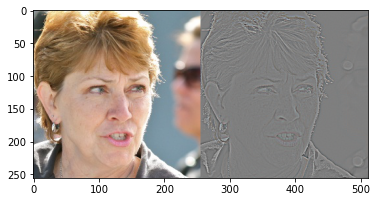

  0%|          | 20/60000 [00:02<2:03:24,  8.10it/s]

249
19
0.37717668121936276 -0.36478917738970595
223.6800537109375 34.47875976562498


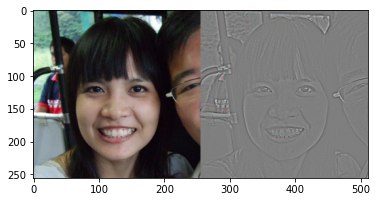

  0%|          | 21/60000 [00:02<1:58:20,  8.45it/s]

223
34
0.7249643363204656 -0.3633734011182598
312.36590576171875 34.83978271484376


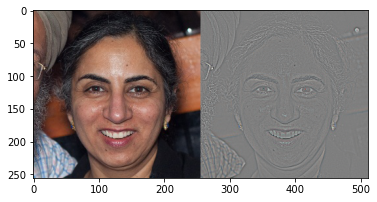

  0%|          | 22/60000 [00:02<1:54:08,  8.76it/s]

235
5
0.6319156422334559 -0.44417724609375
288.63848876953125 14.234802246093755


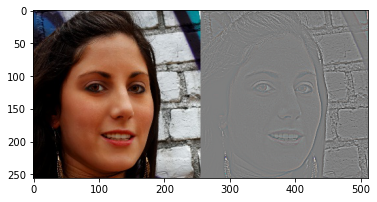

  0%|          | 23/60000 [00:02<1:50:38,  9.04it/s]

254
1
0.6053069469975491 -0.30874310661764703
281.853271484375 48.77050781250001


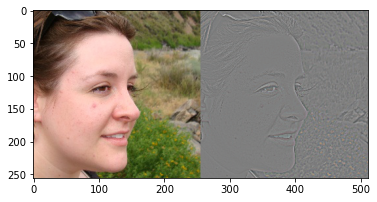

  0%|          | 24/60000 [00:02<1:48:15,  9.23it/s]

206
20
0.6611366421568627 -0.3300312117034314
296.08984375 43.342041015624986


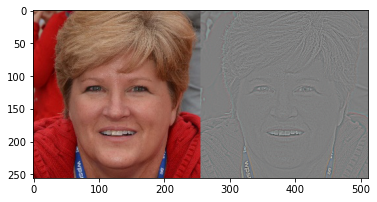

  0%|          | 25/60000 [00:02<1:47:16,  9.32it/s]

214
31
0.3990124272365196 -0.38185915479473026
229.2481689453125 30.125915527343782


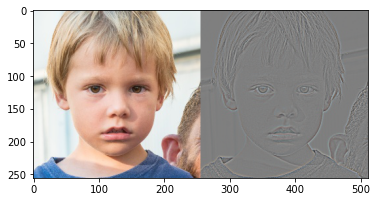

  0%|          | 26/60000 [00:02<1:45:22,  9.49it/s]

229
30
0.42525850183823527 -0.5233984853707108
235.94091796875 -5.966613769531245


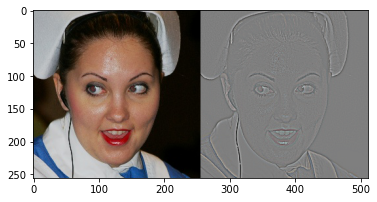

  0%|          | 27/60000 [00:02<1:45:53,  9.44it/s]

253
0
0.3733668907015931 -0.3059397977941176
222.70855712890625 49.48535156250001


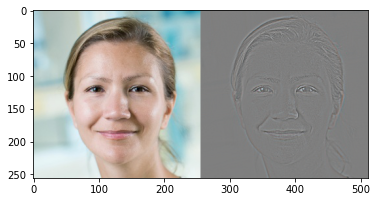

  0%|          | 28/60000 [00:03<1:44:24,  9.57it/s]

222
49
0.6835181142769609 -0.22607326133578431
301.797119140625 69.851318359375


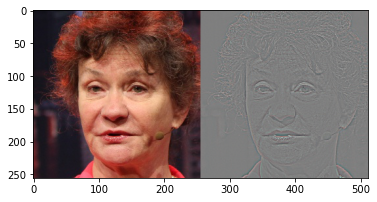

  0%|          | 29/60000 [00:03<1:43:52,  9.62it/s]

220
38
0.4265052945006128 -0.2625507429534314
236.25885009765628 60.54956054687499


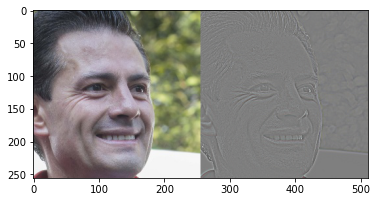

  0%|          | 30/60000 [00:03<1:48:20,  9.23it/s]

236
60


In [55]:
set_ = 'train'
img_file = file_utils._list_image_files_recursively(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/")
img_size = 256
import cv2
from PIL import Image
import blobfile as bf

lap_out = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/laplacian/{set_}/"
os.makedirs(lap_out, exist_ok=True)

def create_gaussian_pyramid(img, level=5):
    pys = [img]
    for i in range(level-1):
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, (int(img.shape[1] / 2), int(img.shape[0] / 2)), interpolation=cv2.INTER_AREA)
        pys.append(img)
    return pys

def create_laplacian_pyramid(img, level=5):
    pys = create_gaussian_pyramid(img, level)
    for i in range(level-1):
        pys[i] = pys[i] - cv2.resize(pys[i+1], (pys[i].shape[1], pys[i].shape[0]))
    return pys

for i, path in enumerate(tqdm.tqdm(img_file)):
    name = path.split('/')[-1].split('.')[0]
    with bf.BlobFile(path, "rb") as f:
        pil_image = Image.open(f)
        pil_image.load()
    pil_image = pil_image.convert("RGB")
    img = np.array(pil_image) / 255
    img_lap = create_laplacian_pyramid(img)
    highest_freq_img = img_lap[0]
    # np.save(file=f"{lap_out}/{name}.npy", arr=highest_freq_img, )
    if i == 30: break
    print(np.max(img_lap[0]), np.min(img_lap[0]))
    highest_freq_img = (img_lap[0] + 0.5) * 255
    print(np.max(highest_freq_img), np.min(highest_freq_img))
    plt.imshow(np.concatenate(((img*255).astype(np.uint8), highest_freq_img.astype(np.uint8)), 1))
    plt.show()
    print(np.max(highest_freq_img.astype(np.uint8)))
    print(np.min(highest_freq_img.astype(np.uint8)))